# Анализ суточных данных по ВНС

In [52]:
import pandas as pd
import numpy as np

dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M')

data_file = 'https://raw.githubusercontent.com/Reki7/pd_balance/master/data/VNS_PU.csv'
#'../vns_pu1.csv'
df = pd.read_csv(data_file, sep=';', decimal=',', parse_dates=['date'], date_parser=dateparse, index_col=['date'])
#df.info()

## Обзор данных
Всего 5 столбцов с данными:
- **press_in2 (Давление вх.2, м вод.ст.)** - нет данных (все нули), можно выкинуть. Возможно, это резервный ввод.
- **press_in1 (Давление вх.1, м вод.ст.)**, **press_out (Давление вых., м вод.ст.)**, **flow (Расход, м3/час)** - все данные есть, разброс небольшой
- **volume (Объем, м3)** - есть нули, разброс очень большой, поскольку это накопительный итог

In [53]:
df.head()

,press_in1,press_in2,press_out,flow,volume
date,,,,,
2017-12-01,41.89,0,74.71,12,106441
2017-12-02,41.92,0,74.15,13,106730
2017-12-03,41.89,0,73.85,14,107044
2017-12-04,42.20,0,75.03,12,107373
2017-12-05,42.06,0,74.64,13,107667


In [54]:
df.describe()

,press_in1,press_in2,press_out,flow,volume
count,435.000000,435.0,435.000000,435.000000,435.000000
mean,40.995195,0.0,70.172368,11.788506,51218.206897
std,1.836065,0.0,4.773738,2.434649,34439.664207
min,34.870000,0.0,55.100000,7.000000,0.000000
25%,39.715000,0.0,65.060000,10.000000,19093.500000
50%,41.550000,0.0,72.020000,11.000000,50821.000000
75%,42.400000,0.0,73.980000,12.000000,82259.000000
max,45.250000,0.0,77.010000,27.000000,116292.000000


In [55]:
df.drop(['press_in2'], axis=1, inplace=True)

## Временной ряд
После преобразования в Timeseries обнаружились даты, для которых не было записей в исходном массиве, они были заполнены NaN

In [56]:
df = df.asfreq(pd.infer_freq(df.index))
#df = df.set_index('date').resample('D').mean().fillna(0)
df.index

DatetimeIndex(['2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10',
               ...
               '2019-02-01', '2019-02-02', '2019-02-03', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
               '2019-02-09', '2019-02-10'],
              dtype='datetime64[ns]', name='date', length=437, freq='D')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 437 entries, 2017-12-01 to 2019-02-10
Freq: D
Data columns (total 4 columns):
press_in1    435 non-null float64
press_out    435 non-null float64
flow         435 non-null float64
volume       435 non-null float64
dtypes: float64(4)
memory usage: 17.1 KB


## Пропущенные данные
Пропущенными считаются дни, для которых нет суточного расхода (нулевой или NaN)

In [58]:
_df_tmp = df[['volume']].copy()

# helper для поиска пропущенных данных
_df_tmp['_v1'] = -_df_tmp['volume'].diff(periods=-1)
_df_tmp['_v1'].fillna(0, inplace=True)
# Для всех отрицательных суточных значений (на границе годов) и нулей (данные не снимались) исходные данные помечаем недействительными
_df_tmp['_is_daily_missing'] = _df_tmp['_v1'] <= 0
# Устранение выбросов на границе годов (для графика)
_df_tmp.loc[_df_tmp['_v1'] < 0, '_v1'] = 0
#df.loc[df['vol_tmp'].isna()] #.reset_index().groupby('vol_tmp')['date'].apply(np.array)

In [59]:
missing_intervals = pd.DatetimeIndex([])
missing_indices = []
for d in _df_tmp[_df_tmp['_is_daily_missing']].index:
    d_start = d - pd.offsets.Day()
    if d_start not in _df_tmp.index:
        d_start = d
    d_end = d + pd.offsets.Day()
    if d_end not in _df_tmp.index:
        d_end = d
    missing_intervals = missing_intervals.union(pd.date_range(start=d_start, end=d_end))
    missing_indices.append(_df_tmp.index.get_loc(d))

#_df_tmp.loc[missing_intervals]

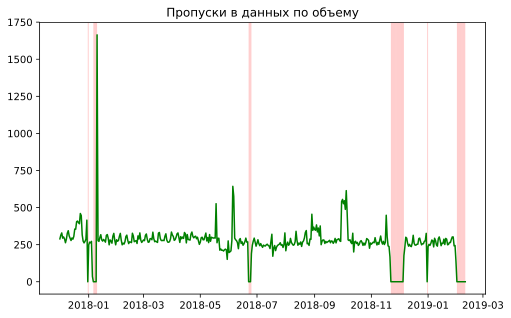

In [60]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
#дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

fig, ax = plt.subplots()
ax.set_title('Пропуски в данных по объему')

#def highlight_datetimes(indices, ax):
ax.plot(_df_tmp['_v1'], 'g-')
for i in missing_indices:
    i2 = i + 1
    if i2 >= len(_df_tmp.index):
        i2 = i
    ax.axvspan(_df_tmp.index[i], _df_tmp.index[i2], facecolor='red', edgecolor='none', alpha=.2)
#plt.savefig('ts_anomaly.png')

### Серийные пропуски
Находим, на каких значениях и на какой период прерывался рост накопительного итога. И на сколько он увеличивался на следующий после этого день.
Из пяти найденных перерывов:
* два однодневных (граница года);
* один на 14 дней, но по его окончанию не было резкого увеличения значения = похоже, что это перерыв в подаче воды, а не в снятии показаний
* один на 10 дней (это конец таблицы, после перерыва данных уже нет)
* один на 4 дня с резким ростом после этого = похоже, это перерыв в снятии показаний

In [61]:
_df_s = _df_tmp[['volume', '_v1', '_is_daily_missing']].copy()

# Недостоверные данные накопительного итога на день опережают недостоверные суточные
_is_cum_missing = _df_tmp['_is_daily_missing'].shift(periods=-1).ffill().to_frame('_is_cum_missing')
_v2 = _df_tmp['_v1'].shift(periods=-1).ffill().to_frame('_v2')
_df_s = pd.concat([_df_s, pd.DataFrame(_is_cum_missing), pd.DataFrame(_v2)], axis=1, join_axes=[_df_s.index])
#_df_s.iloc[missing_indices]

In [62]:
grp = _df_s.iloc[missing_indices].groupby('volume') # Надо добавить в группировку год

mis_df = pd.DataFrame(grp['_v2'].count().to_frame('count'))
mis_df = mis_df.rename(columns={'_v2': 'count'})
mis_df['mean'] = grp['_v2'].mean()
mis_df['sum'] = grp['_v2'].sum()

mis_df

,count,mean,sum
volume,,,
1085.0,4,416.000000,1664.0
8134.0,10,0.000000,0.0
49218.0,1,0.000000,0.0
92527.0,14,12.571429,176.0
99081.0,1,237.000000,237.0
116292.0,1,248.000000,248.0


### Перерывы в снятии показаний

In [63]:
counter_err = mis_df[(mis_df['count']>1) & (mis_df['mean']>(_df_tmp['_v1'].mean()/2))]
counter_err.index.values

array([1085.])

In [64]:
_df_tmp['_vol_tmp'] = _df_tmp['volume']
# Зачистка повторяющихся значений для последующей интерполяции
for i in counter_err.index.values:
    _df_tmp.loc[_df_tmp['_vol_tmp'] == i, '_vol_tmp'] = np.NaN

In [65]:
_df_tmp['_vol_daily'] = -_df_tmp['_vol_tmp'].diff(periods=-1)
_df_tmp['_vol_daily'].fillna(0, inplace=True)
# Устранение выбросов на границе годов (для графика)
_df_tmp.loc[_df_tmp['_vol_daily'] < 0, '_vol_daily'] = 0
#_df_tmp.iloc[missing_indices]

### Заполнение пропущенных значений с помощью интерполяции

In [66]:
df['_volume_fixed'] = _df_tmp['_vol_tmp']

df['_volume_fixed'].interpolate(inplace=True) # method='time'
df['press_in1'].interpolate(inplace=True)
df['press_out'].interpolate(inplace=True)
df['flow'].interpolate(inplace=True)
#df.loc[missing_inerval]

## Расчет посуточных значений из накопительного объема
Поскольку в исходных данных везде было указано время 0:00, считаем, что показания прибора снимались в это время и данные относятся к предыдущему дню. Поэтому разницу между накопительным объемом текущего и предыдущего дней записываем в качестве суточного объема предыдущего дня.

Первого января происходило обнуление накопительного объема, поэтому для 31-го декабря получаются отрицательные значения. Заменяем их нулями.

In [67]:
df['volume_d_'] = -df['_volume_fixed'].diff(periods=-1)
# Для последнего дня таблицы расчитать суточный объем невозможно - поэтому обнуляем
df['volume_d_'].fillna(0, inplace=True)
#df.drop(['cum_vol'], axis=1, inplace=True)
# Замена отрицательных значений на границе года нулями
df.loc[df['volume_d_'] < 0, 'volume_d_'] = 0

data_cols = ['volume_d_', 'flow', 'press_in1', 'press_out']

In [68]:
df_full = df.copy()
df = df[df['volume_d_'] > 0]

## Анализ данных

In [69]:
df.describe()

,press_in1,press_out,flow,volume,_volume_fixed,volume_d_
count,411.000000,411.000000,411.000000,409.000000,411.000000,411.000000
mean,40.887591,70.530243,11.868613,50581.488998,50586.929440,284.832117
std,1.844302,4.684532,2.443960,33782.017780,33685.149661,57.752952
min,34.870000,55.100000,7.000000,0.000000,0.000000,136.000000
25%,39.625000,65.535000,11.000000,20146.000000,20281.000000,257.000000
50%,41.180000,72.170000,11.000000,50111.000000,49813.333333,276.000000
75%,42.270000,74.050000,12.000000,79159.000000,78915.000000,296.000000
max,45.250000,77.010000,27.000000,115877.000000,115877.000000,643.000000


### Графики измеряемых параметров
* __volume (Суточный отпуск, м3)__ - Три резких и коротких всплеска, три менее резких, но более продолжительных. Длительный провал в конце ноября - авария и приостановка подачи воды? В целом во второй половине 2018 года средний уровень немного ниже, чем в первой, а нестабильностей больше.
* __flow (Расход, м3/час)__ - График в целом повторяет форму графика Суточного отпуска
* __press_out (Давление вых., м вод.ст.)__ - По форме зеркально соответствует графикам Расхода и Суточного отпуска. С апреля по сентябрь небольшая просадка - окончание отопительного периода? В начале октября скачкообразно упало среднее значение - поменяли уставку (с примерно 72-75 до 65)?
* __press_in (Давление вх.1, м вод.ст.)__ - по форме самый стабильный график, без резких всплесков. Летом наблюдается небольшая просадка.

На всех графиках виден недельный ритм.

В начале января 2018 был провал в исходных данных, который коснулся всех графиков - похоже, на какие-то проблемы со съемом данных с ПУ.

В конце ноября был еще более долгий провал, но он виден только на графиках Расхода и Суточного отпуска, а давление на выходе держалось в норме. Что это могло быть?

In [70]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

In [71]:
# matplotlib.style.available
# matplotlib.style.use('classic')
#a = df[data_cols].plot(subplots=True, figsize=(10, 10), grid=True, x_compat=True)

# Вариант с plotly
%run ./plotly_df.py
plotly_df(df[['volume_d_']], title = 'Суточный отпуск')
plotly_df(df[['flow', 'press_in1', 'press_out']], title = 'Давления и расход')

<Figure size 576x360 with 0 Axes>

### Матрица рассеяния
* __volume (Суточный отпуск, м3)__ - По гистограмме видно, что распределение вполне равномерное, только в районе нуля есть пик из-за потерянных данных
* __flow (Расход, м3/час)__ - Более-менее равномерное распределение с хвостом справа. И хорошо видна дискретность (полосатость на диаграммах рассеяния)
* __press_out (Давление вых., м вод.ст.)__ - хорошо видно два кластера, до и после смены режима в конце сентября

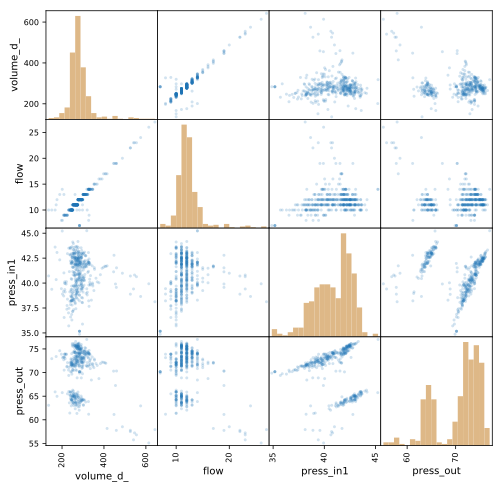

In [72]:
from pandas.plotting import scatter_matrix
a = scatter_matrix(df[data_cols], alpha=0.2, figsize=(8, 8), hist_kwds={'color':['burlywood'], 'bins':20})#, diagonal='kde')

# Variant 2
#%run ./scatter_matrix_lowess.py
#fig = scatter_matrix_lowess1(df[data_cols], alpha=0.4, figsize=(10,10), hist_kwds={'bins':20});
#fig.suptitle('Scatterplot matrix with lowess smoother', fontsize=16);

### Коробчатые диаграммы
На коробчатых диаграммах нагляднее виден характер распределения, особенно длинные хвосты выбросов у volume

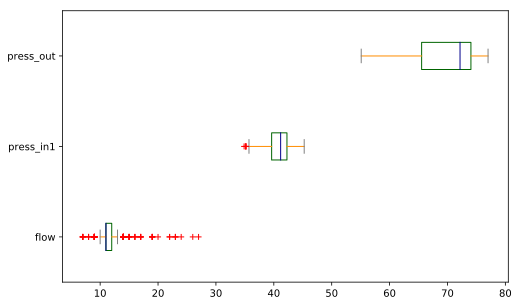

In [73]:
bp_color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
df[['flow', 'press_in1', 'press_out']].plot.box(color=bp_color, vert=False, sym='r+')

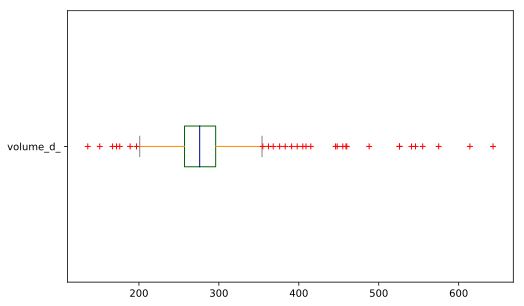

In [74]:
df[['volume_d_']].plot.box(color=bp_color, vert=False, sym='r+')

### Периодические колебания (сезонность)
Для годовых циклов данных пока мало, но недельные периоды видны на всех графиках.

Еще можно посмотреть на графики разложения наблюдаемых параметров на три составляющие - периодическая (несущая, сезонность), тренд (более медленные изменения) и отклонения.

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_full[data_cols], model='additive') # model='multiplicative')

%run ./plotly_df.py
layout = dict(title = 'Расход (м3/ч)') #yaxis = dict(zeroline = False), xaxis = dict(zeroline = False)
fig = dict(data=decomposition_data(decomposition, df_full, 'flow'), layout=layout)
iplot(fig) #, filename='styled-scatter')

<Figure size 576x360 with 0 Axes>

In [76]:
layout = dict(title = 'Давление выход (м. вод.ст.)') 
fig = dict(data=decomposition_data(decomposition, df_full, 'press_out'), layout=layout)
iplot(fig)

## Время
Категоризация данных по месяцам, дням недели, будним/выходным дням.

### Матрица корреляции
По матрице видно, что достаточно сильная прямая корреляция есть только между Расходом и Суточным отпуском (92%).

Давление на входе почему-то имеет слабую обратную корреляцию (синие цвета) со всеми остальными параметрами кроме Суточного отпуска. Это также было заметно на графиках переменных.

In [77]:
df['month_'] = df.index.month
df['day_'] = df.index.day
df['dayofweek_'] = df.index.dayofweek
df['dayofyear_'] = df.index.dayofyear

# Праздники и переносы рабочих дней
holidays_2018 = ['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', 
                 '2018-01-08', '2018-02-23', '2018-03-08', '2018-03-09', '2018-04-30', 
                 '2018-05-01', '2018-05-02', '2018-05-09', '2018-06-11', '2018-06-12', 
                 '2018-11-05', '2018-12-31']
moved_wd_2018 = ['2018-04-28', '2018-06-09','2018-12-29']
holidays_2019 = ['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
                 '2019-01-08']
df['is_workday_'] = np.logical_not(df['dayofweek_'].isin([5,6]) | df.index.isin(holidays_2018) & ~df.index.isin(moved_wd_2018)) 

#df['dayofweek_name'] = df.dayofweek.map(pd.Series('Mon Tue Wed Thu Fri Sat Sun'.split()))
#df.index.month_name()

date_cols = ['month_', 'day_', 'dayofweek_', 'dayofyear_', 'is_workday_'] #'dayofweek_name'
#date_cols = [col for col in df.columns if 'day' in col]

,volume_d_,flow,press_in1,press_out,month_,dayofweek_
volume_d_,1.000000,0.920254,-0.008596,-0.254150,0.113452,0.095091
flow,0.920254,1.000000,0.132770,-0.251384,0.142341,0.085984
press_in1,-0.008596,0.132770,1.000000,-0.117374,0.116763,-0.146789
press_out,-0.254150,-0.251384,-0.117374,1.000000,-0.317928,-0.092774
month_,0.113452,0.142341,0.116763,-0.317928,1.000000,0.026616
dayofweek_,0.095091,0.085984,-0.146789,-0.092774,0.026616,1.000000


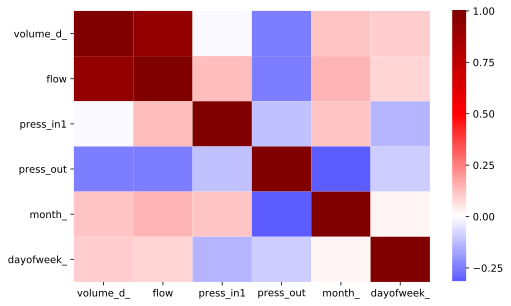

In [78]:
corr_matrix = df[data_cols + ['month_', 'dayofweek_']].corr()
sns.heatmap(corr_matrix, center=0, cmap="seismic");
corr_matrix

### Влияние будней/праздников
На диаграмме рассения на первый взгляд не видно никаких существенных отличий будней (зеленое) от выходных и праздников (красное)

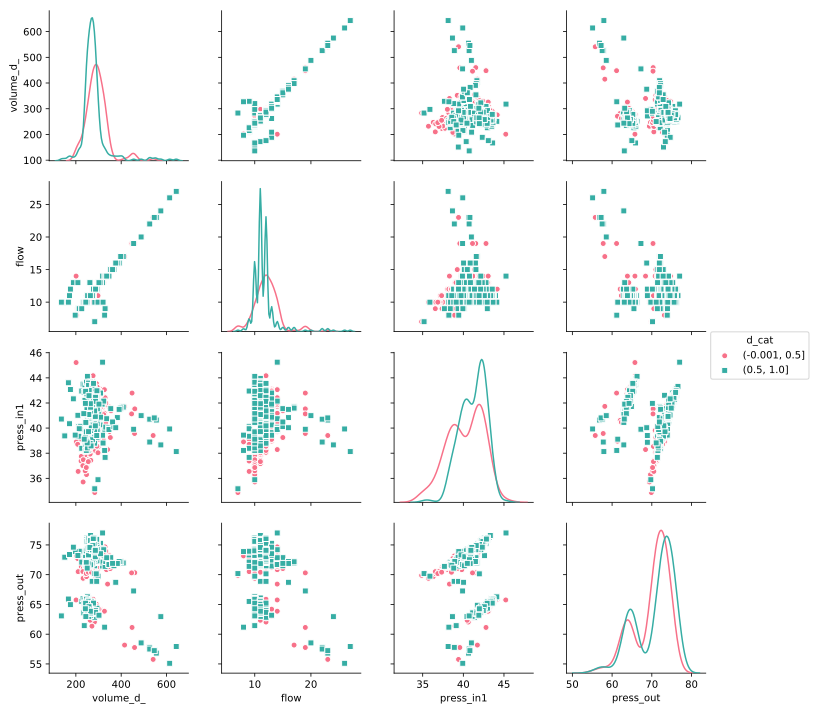

In [79]:
df['d_cat'] = pd.cut(df['is_workday_'], bins=2)
ax = sns.pairplot(df[data_cols + ['d_cat']],
                 hue="d_cat",
                 diag_kind="kde",
                 hue_order=df['d_cat'].cat.categories,
                 markers=["o", "s"],
#                 height=1.5,
                 palette='husl') #"YlGnBu"
#ax.set(xlabel='common xlabel', ylabel='common ylabel')                
plt.show()
#g.savefig("pairplot.png")

### Среднемесячный отпуск
При сравнении отпуска по месяцам видно, что с мая по август (а потом еще и в октябре) среднесуточное потребление в выходные дни превышает потребление в будни. Все уехали на дачу? А что с октябрем? 

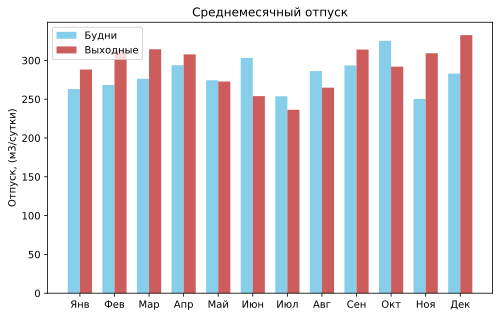

In [80]:
wd_vol = df[df['is_workday_']].groupby('month_')['volume_d_'].mean()
we_vol = df[~df['is_workday_']].groupby('month_')['volume_d_'].mean()

months_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
ind = np.arange(len(months_names))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, wd_vol, width, color='SkyBlue', label='Будни')
rects2 = ax.bar(ind + width/2, we_vol, width, color='IndianRed', label='Выходные')
ax.set_ylabel('Отпуск, (м3/сутки)')
ax.set_title('Среднемесячный отпуск')
ax.set_xticks(ind)
ax.set_xticklabels(months_names)
ax.legend()

plt.show()

### Отпуск по дням недели
В течение недели резких отличий в потреблении нет. В воскресенье чуть больше, в четверг чуть меньше среднего.

На коробчатых диаграммах тоже видно, что среднее воскресеное среднее больше других дней. Но и разброс (ширина коробочек) у субботы и воскресенья гораздо больше других дней.

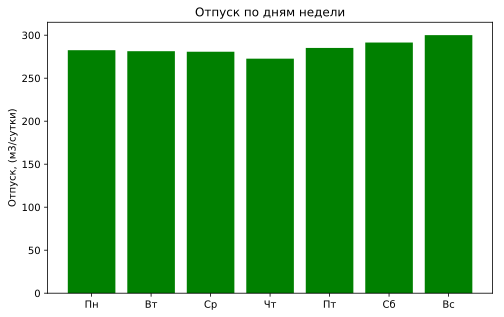

In [81]:
week_vol = df.groupby('dayofweek_')['volume_d_'].mean()

dow_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
ind = np.arange(len(dow_names))
width = 0.35

fig, ax = plt.subplots()
ax.bar(ind, week_vol, align='center', color='green', ecolor='black')
ax.set_ylabel('Отпуск, (м3/сутки)')
ax.set_title('Отпуск по дням недели')
ax.set_xticks(ind)
ax.set_xticklabels(dow_names)
plt.show()

In [82]:
# plotly
data = []
days = df['dayofweek_'].unique()
days[::-1].sort()
for dow in days:
    data.append(go.Box(x=df[df['dayofweek_']==dow]['volume_d_'], name=dow_names[dow]))   #.astype(str)
layout = go.Layout(
    title='Суточный отпуск по дням недели',
    yaxis=dict(title='random distribution'),
    xaxis=dict(title='linspace')
)
iplot(data, show_link = False)

# sns
#sns.boxplot(y="dayofweek_", x="volume_d_", data=df, orient="h")

### Тепловая карта
На карте зависимости суточного отпуска от дня недели и месяца года видно снижение потребления в июле и ноябре (темные цвета), а самый большой отпуск был по вторникам и средам в июне и по пятницам в октябре.

In [83]:
dow_volumes = df.pivot_table(
                        index='dayofweek_', 
                        columns='month_', 
                        values='volume_d_', 
                        aggfunc=np.mean).fillna(0).applymap(float)
#dow_volumes.info()
#sns.heatmap(dow_volumes, annot=True, fmt=".1f", linewidths=.5) # fmt=".1f", 
hm = [go.Heatmap(z=dow_volumes.values.tolist(),
                 x=months_names,
                 y=dow_names,
#                 title = 'Отпуск в зависимости от дня недели и месяца года',
                 colorscale='Viridis')] #.index) #, y=dow_volumes['dayofweek_'])
iplot(hm, filename='pandas-heatmap')

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')